In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/1e7datasetcorr.csv', index_col=0)
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
4995,True,1.000000e+07,10000000.0,0.000015,0.021544,0.053729,0.012454,0.005642,-1.657512,0.012805,...,-2.455928,-0.162476,0.008390,-0.073445,0.000225,23.145675,2.707954,0.045366,2.622256e-09,1437.494908
4996,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056524,0.013439,0.003143,0.454508,0.016073,...,2.849398,1.906923,-0.025937,0.072181,-0.000593,-21.424946,-7.242948,0.126097,1.469989e-08,1502.892072
4997,True,1.000000e+07,10000000.0,0.000015,0.021544,0.058060,0.013990,0.009825,-0.543930,0.013198,...,1.792055,0.982644,-0.007582,0.076548,-0.000043,-22.647292,-2.002117,0.103816,7.680985e-09,1408.293117
4998,False,2.365555e+05,10000000.0,0.000015,0.021544,0.052558,0.012049,0.003733,-3.677540,0.004648,...,-3.022916,0.840517,0.031328,-0.060568,0.000609,21.634522,10.844146,-0.078264,6.473084e-07,33.453553
4999,False,1.997705e+04,10000000.0,0.000015,0.021544,0.051719,0.011762,0.015866,1.766786,0.011312,...,-1.104623,2.694640,0.067710,0.016891,0.000328,-5.630598,22.998094,0.025569,8.613444e-07,3.079377


In [2]:
from sklearn.cross_validation import train_test_split
X = df.ix[:, 1:]
y = df.ix[:,0]
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
holdoutdf = pd.concat([y_holdout, X_holdout], axis=1)
traindf = pd.concat([y_train, X_train], axis=1)
holdoutdf.to_csv('../data/1e7data_holdout.csv', encoding='ascii')
traindf.to_csv('../data/1e7data_train.csv', encoding='ascii')

# First do Stability over 1e6 orbits to compare to previous dataset

In [4]:
columns = []
for i in ['1', '2', '3']:
    #columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i, 'x'+i, 'y'+i, 'z'+i, 'vx'+i, 'vy'+i, 'vz'+i]
    columns += ['P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

def stable1e6(Norbits):
    if Norbits > 1e6:
        return True
    else:
        return False
    
y_train = X_train['Norbits_instability'].map(stable1e6)
X_train = X_train[columns]
y_holdout = X_holdout['Norbits_instability'].map(stable1e6)
X_holdout = X_holdout[columns]
X_train.shape

(3500, 18)

In [5]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
  
cv_s = StratifiedShuffleSplit(y_train,  n_iter=10 , test_size=0.1, random_state=42)
rfc = RandomForestClassifier(max_features= 'auto' ,n_estimators=50) 
param_grid = { 
        'n_estimators': [500],
        'max_features': ['sqrt']}
CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="roc_auc", param_grid=param_grid, cv=cv_s)
CV_rfc.fit(X_train, y_train)
print("The best parameters are {%s} with a score of %0.4f" % (CV_rfc.best_params_, CV_rfc.best_score_))
model = CV_rfc.best_estimator_
y_pred = model.predict_proba(X_holdout)
y_pred_acc = model.predict(X_holdout)
from sklearn import metrics
test_score = metrics.roc_auc_score(y_holdout, y_pred[:,1])
test_score_acc = metrics.accuracy_score(y_holdout, y_pred_acc)
print("AUC score is {0}".format(test_score))
print("Accuracy is {0}".format(test_score_acc))

The best parameters are {{'max_features': 'sqrt', 'n_estimators': 500}} with a score of 0.7945
AUC score is 0.792463549075
Accuracy is 0.718


# Now do stability over 1e7 orbits

In [6]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
X_train = X_train[columns]
X_holdout = X_holdout[columns]

In [7]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

cv_s = StratifiedShuffleSplit(y_train,  n_iter=10 , test_size=0.1, random_state=42)
rfc = RandomForestClassifier(max_features= 'auto' ,n_estimators=50) 
param_grid = { 
        'n_estimators': [500],
        'max_features': ['sqrt']}
CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="roc_auc", param_grid=param_grid, cv=cv_s)
CV_rfc.fit(X_train, y_train)
print("The best parameters are {%s} with a score of %0.4f" % (CV_rfc.best_params_, CV_rfc.best_score_))
model = CV_rfc.best_estimator_
y_pred = model.predict_proba(X_holdout)
y_pred_acc = model.predict(X_holdout)
from sklearn import metrics
test_score = metrics.roc_auc_score(y_holdout, y_pred[:,1])
test_score_acc = metrics.accuracy_score(y_holdout, y_pred_acc)
print("AUC score is {0}".format(test_score))
print("Accuracy is {0}".format(test_score_acc))

The best parameters are {{'max_features': 'sqrt', 'n_estimators': 500}} with a score of 0.7826
AUC score is 0.765049140049
Accuracy is 0.740666666667


# Now we predict on datasets that draw from the simulation states at different times

In [8]:
amin=0.04
Pmin = amin**1.5
Ndfs=10
indices=np.int64(np.linspace(0,565,Ndfs))
print(indices)
outcolumns = ['t']
for i in ['1', '2', '3']:
    outcolumns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
out0 = pd.read_csv('../data/corrdata/output0.csv', names=outcolumns)
orbits = [] # number of orbits elapsed before drawing each new test dataset
for index in indices:
    orbits.append(out0.loc[index, 't']/Pmin) #using Pmin means we always get the max # of orbits possible for given t
print(orbits)

orbits_cutoff = orbits[-1]
train_ids = X_train.index
dfcut = df.loc[train_ids]
dfcut = dfcut[dfcut['Norbits_instability'] > orbits_cutoff] # take only ones that survive > orbits_cutoff
print("{0} systems in training data (/{1})survived longer than {2:.1e} orbits".format(dfcut.shape[0], X_train.shape[0], orbits_cutoff))

Xs = [pd.DataFrame(index=dfcut.index, columns=columns, dtype=np.float64) for i in range(Ndfs)]
#Norbits = [pd.Series(index=dfcut.index, dtype=np.float64) for i in range(Ndfs)]
ys = [pd.Series(index=dfcut.index, dtype=bool) for i in range(Ndfs)]

ids = dfcut.index
for ID in ids:
    rundf = pd.read_csv('../data/corrdata/output'+str(ID)+'.csv', names=outcolumns)
    P0 = df.loc[ID, 'P1']
    for j, index in enumerate(indices):
        P1 = rundf.loc[index, 'P1']
        Xs[j].loc[ID] = rundf.loc[index, columns]
        #Norbits[j].loc[ID] = (df.loc[ID, 'Norbits_instability']*P0 - rundf.loc[index, 't'])/P1 # just use original target, see below
        #ys[j].loc[ID] = Norbits[j].loc[ID] > 1e7-orbits_cutoff

[  0  62 125 188 251 313 376 439 502 565]
[125.0, 260.28286520124999, 548.42698400250003, 1155.5588054174998, 2434.8111812999996, 5069.9170439499994, 10682.529222237499, 22508.540000624998, 47426.44390875, 99929.519274249993]
2512 systems in training data (/3500)survived longer than 1.0e+05 orbits


# orbits_cutoff = 1e5 orbits << 1e7, so for simplicity let's just take the target from the original dataset (if it's stable over 1e7 years, it's probably stable over 0.99e7 years).

In [9]:
for j in range(Ndfs):
    ys[j] = dfcut['Stable']

In [10]:
import random

print("Using datasets created after N_orbits = {0}".format(orbits))
Nholdout = y_holdout.shape[0]
Nsamples = Xs[0].shape[0] # how many simulations there are in the X for each slice in time

Nseeds = 10
test_scores, test_scores_acc = np.zeros((Ndfs, Nseeds)), np.zeros((Ndfs, Nseeds))

for seed in range(Nseeds):
    random.seed(seed)
    for i in range(Ndfs):
        sample = random.sample(ids,Nholdout) # get sample of Nholdout values from ids without replacement
        Xtest = Xs[i].loc[sample]
        ytest = ys[i].loc[sample]
        y_pred = model.predict_proba(Xtest)
        y_pred_acc = model.predict(Xtest)
        test_scores[i, seed] = metrics.roc_auc_score(ytest, y_pred[:,1])
        test_scores_acc[i, seed] = metrics.accuracy_score(ytest, y_pred_acc)

Using datasets created after N_orbits = [125.0, 260.28286520124999, 548.42698400250003, 1155.5588054174998, 2434.8111812999996, 5069.9170439499994, 10682.529222237499, 22508.540000624998, 47426.44390875, 99929.519274249993]


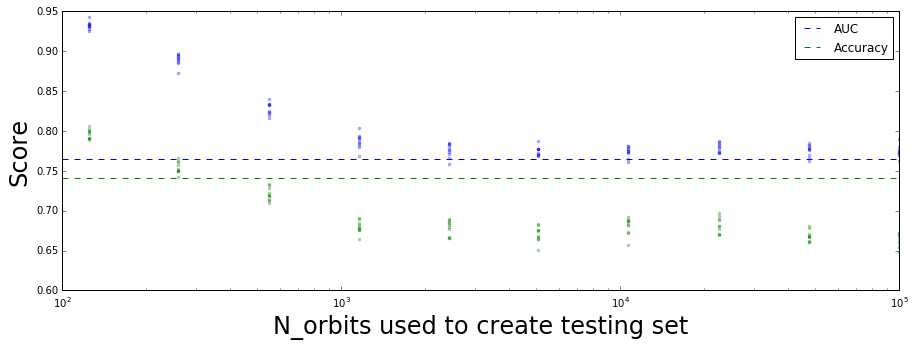

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
for i, orbit in enumerate(orbits):
    ax.plot([orbit]*Nseeds, test_scores[i,:], color='b', marker='.', linestyle='', alpha=0.3)
    ax.plot([orbit]*Nseeds, test_scores_acc[i,:], color='g', marker='.', linestyle='', alpha=0.3)
ax.axhline(test_score, color='b', linestyle='--', label='AUC')
ax.axhline(test_score_acc, color='g', linestyle='--', label='Accuracy')
ax.set_xscale('log')
ax.set_xlabel('N_orbits used to create testing set', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
plt.legend()

Horizontal lines are the scores from the best-fit model that just uses the training data.  Points are scores if we instead predict on a sample drawn at the time on the x axis. 

It seems like for short times, our drawn sample is too correlated to the training data, so the model is able to predict much better than it can on out-of-sample data.  However, beyond about 1e3 orbits, the model achieves the same AUC on out-of-sample data as on a dataset generated from states within each integration.  This may suggest we can greatly increase our sample size.

For some reason the accuracy doesn't seem to follow this trend.  It seems to predict worse on the generated datasets than on out-of-sample data, which seems counterintuitive.  It seems like a bug but I haven't been able to find it yet.

# Test whether drop in accuracy is because we omitted N_orbits_instability < 1e5 orbits

Here I take only the simulations in the holdout set that also have N_orbits_instability > 1e5 orbits (like I did with the datasets drawn at different time) to see if I get comparable results.  

In [74]:
holdoutdfcut = holdoutdf[holdoutdf['Norbits_instability'] > orbits_cutoff] # take only ones that survive > orbits_cutoff
holdoutdfcut_ids = holdoutdfcut.index
X_holdoutcut = X_holdout.loc[holdoutdfcut_ids]
y_holdoutcut = y_holdout.loc[holdoutdfcut_ids]

traindfcut = traindf[traindf['Norbits_instability'] > orbits_cutoff]
traindfcut_ids = traindfcut.index
X_traincut = X_train.loc[traindfcut_ids]
y_traincut = y_train.loc[traindfcut_ids]

In [75]:
print("holdout fraction unstable = {0}".format(dfholdoutcut['Stable'].value_counts()[0]/float(dfholdoutcut['Stable'].shape[0])))

holdout fraction unstable = 0.592286501377


In [76]:
print("holdout fraction unstable when not cut = {0}".format(dfholdout['Stable'].value_counts()[0]/float(dfholdout['Stable'].shape[0])))

holdout fraction unstable when not cut = 0.704


In [77]:
for j in range(Ndfs):
    print("y[{0}] fraction unstable = {1}".format(j, ys[j].value_counts()[0]/float(len(ys[j]))))

y[0] fraction unstable = 0.587977707006
y[1] fraction unstable = 0.587977707006
y[2] fraction unstable = 0.587977707006
y[3] fraction unstable = 0.587977707006
y[4] fraction unstable = 0.587977707006
y[5] fraction unstable = 0.587977707006
y[6] fraction unstable = 0.587977707006
y[7] fraction unstable = 0.587977707006
y[8] fraction unstable = 0.587977707006
y[9] fraction unstable = 0.587977707006


In [78]:
ys[8].value_counts()

False    1477
True     1035
Name: Stable, dtype: int64

In [79]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

cv_s = StratifiedShuffleSplit(y_traincut,  n_iter=10 , test_size=0.1, random_state=42)
rfc = RandomForestClassifier(max_features= 'auto' ,n_estimators=50) 
param_grid = { 
        'n_estimators': [500],
        'max_features': ['sqrt']}
CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="roc_auc", param_grid=param_grid, cv=cv_s)
CV_rfc.fit(X_traincut, y_traincut)
model = CV_rfc.best_estimator_
y_pred = model.predict_proba(X_holdoutcut)
y_pred_acc = model.predict(X_holdoutcut)
from sklearn import metrics
test_score_cut = metrics.roc_auc_score(y_holdoutcut, y_pred[:,1])
test_score_acc_cut = metrics.accuracy_score(y_holdoutcut, y_pred_acc)
print("AUC score is {0}".format(test_score_cut))
print("Accuracy is {0}".format(test_score_acc_cut))

AUC score is 0.699301627209
Accuracy is 0.660238751148


In [80]:
print("Percent stable in holdout set = {0}".format(y_holdout.value_counts()[1]/float(y_holdout.shape[0])))
print("Percent stable in holdout set with systems with Norbits_instability < 1e5 removed = {0}".format(y_holdoutcut.value_counts()[1]/float(y_holdoutcut.shape[0])))
print("Percent stable in dataset drawn at 1e5 years = {0}".format(ys[-1].value_counts()[1]/float(ys[-1].shape[0])))

Percent stable in holdout set = 0.296
Percent stable in holdout set with systems with Norbits_instability < 1e5 removed = 0.407713498623
Percent stable in dataset drawn at 1e5 years = 0.412022292994


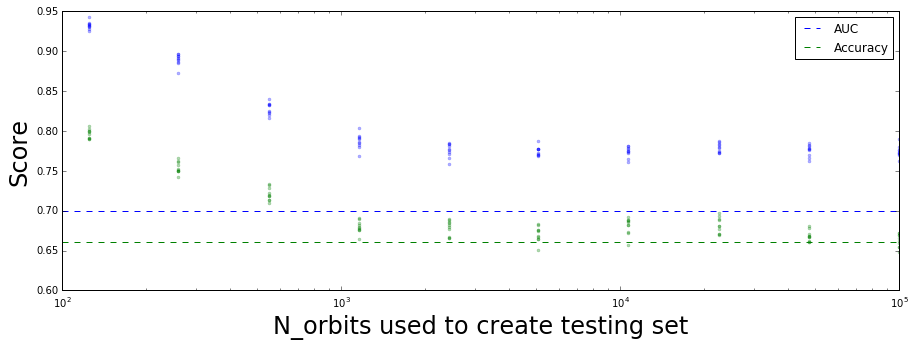

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
for i, orbit in enumerate(orbits):
    ax.plot([orbit]*Nseeds, test_scores[i,:], color='b', marker='.', linestyle='', alpha=0.3)
    ax.plot([orbit]*Nseeds, test_scores_acc[i,:], color='g', marker='.', linestyle='', alpha=0.3)
ax.axhline(test_score_cut, color='b', linestyle='--', label='AUC')
ax.axhline(test_score_acc_cut, color='g', linestyle='--', label='Accuracy')
ax.set_xscale('log')
ax.set_xlabel('N_orbits used to create testing set', fontsize=24)
ax.set_ylabel('Score', fontsize=24)
plt.legend()

# std of 0.02 gives some measure of what a significant improvement is

In [57]:
CV_rfc.grid_scores_

[mean: 0.78719, std: 0.02142, params: {'max_features': 'sqrt', 'n_estimators': 500}]

# How much does using dataset extracted after `orbits` number of orbits help us predict on out of sample data?

In [58]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

for j in range(Ndfs):
    X_test = pd.concat([X_train, Xs[j]])
    y_test = pd.concat([y_train, ys[j]])
    
    cv_s = StratifiedShuffleSplit(y_train,  n_iter=10 , test_size=0.1, random_state=42)
    rfc = RandomForestClassifier(max_features= 'auto' ,n_estimators=50) 
    param_grid = { 
            'n_estimators': [500],
            'max_features': ['sqrt']}
    CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="roc_auc", param_grid=param_grid, cv=cv_s)
    
    CV_rfc.fit(X_test, y_test)
    model = CV_rfc.best_estimator_
    y_pred = model.predict_proba(X_holdout)
    y_pred_acc = model.predict(X_holdout)
    from sklearn import metrics
    test_score = metrics.roc_auc_score(y_holdout, y_pred[:,1])
    test_score_acc = metrics.accuracy_score(y_holdout, y_pred_acc)
    print("orbits={0}, AUC score is {1}".format(orbits[j], test_score))

orbits=125.0, AUC score is 0.78336788493
orbits=260.282865201, AUC score is 0.786600165506
orbits=548.426984003, AUC score is 0.778486938643
orbits=1155.55880542, AUC score is 0.776893726112
orbits=2434.8111813, AUC score is 0.77924728706
orbits=5069.91704395, AUC score is 0.779792221198
orbits=10682.5292222, AUC score is 0.782512626263
orbits=22508.5400006, AUC score is 0.770819470038
orbits=47426.4439087, AUC score is 0.777495179839
orbits=99929.5192742, AUC score is 0.778514665233
